In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD

In [2]:
dataset = pd.read_csv('bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')
dataset

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
4857372,1617148560,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339
4857373,1617148620,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508
4857374,1617148680,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496
4857375,1617148740,58742.18,58770.38,58742.18,58760.59,0.720415,42332.958633,58761.866202


In [3]:
dataset[dataset.columns.values] = dataset[dataset.columns.values].ffill()

In [4]:
dataset=dataset.drop(columns=['Timestamp'])

In [6]:
# Create short simple moving average over the short window
dataset['short_mavg'] = dataset['Close'].rolling(window=7, min_periods=1,\
center=False).mean()
# Create long simple moving average over the long window
dataset['long_mavg'] = dataset['Close'].rolling(window=70, min_periods=1,\
center=False).mean()
# Create signals
dataset['signal'] = np.where(dataset['short_mavg'] >
dataset['long_mavg'], 1.0, 0.0)

In [7]:
dataset.head(5)

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,short_mavg,long_mavg,signal
0,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,4.39,4.39,0.0
1,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,4.39,4.39,0.0
2,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,4.39,4.39,0.0
3,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,4.39,4.39,0.0
4,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,4.39,4.39,0.0


# Feature engineering

# Moving average
A moving average provides an indication of a price trend by cutting down the
amount of noise in the series.
# Stochastic oscillator %K
A stochastic oscillator is a momentum indicator that compares the closing price
of a security to a range of its previous prices over a certain period of time. %K
and %D are slow and fast indicators. The fast indicator is more sensitive than the
slow indicator to changes in the price of the underlying security and will likely
result in many transaction signals.
# Relative strength index (RSI)
This is a momentum indicator that measures the magnitude of recent price
changes to evaluate overbought or oversold conditions in the price of a stock or
other asset. The RSI ranges from 0 to 100. An asset is deemed to be overbought
once the RSI approaches 70, meaning that the asset may be getting overvalued
and is a good candidate for a pullback. Likewise, if the RSI approaches 30, it is an
indication that the asset may be getting oversold and is therefore likely to become
undervalued.
# Rate of change (ROC)
This is a momentum oscillator that measures the percentage change between the
current price and the n period past prices. Assets with higher ROC values are
considered more likely to be overbought; those with lower ROC, more likely to
be oversold.
# Momentum (MOM)
This is the rate of acceleration of a security’s price or volume—that is, the speed
at which the price is changing.

In [11]:
#calculation of exponential moving average
def EMA(df, n):
    EMA = pd.Series(df['Close'].ewm(span=n, min_periods=n).mean(), name='EMA_'+ str(n))
    return EMA
dataset['EMA14'] = EMA(dataset, 14)
dataset['EMA21'] = EMA(dataset, 21)
dataset['EMA200'] = EMA(dataset, 200)
dataset.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,short_mavg,long_mavg,signal,EMA10,EMA30,EMA200,EMA14,EMA21
0,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,4.39,4.39,0.0,NaN,NaN,NaN,NaN,NaN
1,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,4.39,4.39,0.0,NaN,NaN,NaN,NaN,NaN
2,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,4.39,4.39,0.0,NaN,NaN,NaN,NaN,NaN
3,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,4.39,4.39,0.0,NaN,NaN,NaN,NaN,NaN
4,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,4.39,4.39,0.0,NaN,NaN,NaN,NaN,NaN


In [13]:
#calculation of rate of change
def ROC(df, n):
    M = df.diff(n - 1)
    N = df.shift(n - 1)
    ROC = pd.Series(((M / N) * 100), name = 'ROC_' + str(n))
    return ROC
dataset['ROC14'] = ROC(dataset['Close'], 10)
dataset['ROC21'] = ROC(dataset['Close'], 30)

In [15]:
#calculation of price momentum
def MOM(df, n):
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))
    return MOM
dataset['MOM14'] = MOM(dataset['Close'], 14)
dataset['MOM21'] = MOM(dataset['Close'], 21)

In [16]:
#calculation of relative strength index
def RSI(series, period):
    delta = series.diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
    u = u.drop(u.index[:(period-1)])
    d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
    d = d.drop(d.index[:(period-1)])
    rs = u.ewm(com=period-1, adjust=False).mean() / \
    d.ewm(com=period-1, adjust=False).mean()
    return 100 - 100 / (1 + rs)
dataset['RSI14'] = RSI(dataset['Close'], 14)
dataset['RSI21'] = RSI(dataset['Close'], 21)
dataset['RSI200'] = RSI(dataset['Close'], 200)

In [17]:
#calculation of stochastic osillator.
def STOK(close, low, high, n):
    STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - \
    low.rolling(n).min())) * 100
    return STOK
def STOD(close, low, high, n):
    STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - \
    low.rolling(n).min())) * 100
    STOD = STOK.rolling(3).mean()
    return STOD
dataset['%K14'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 14)
dataset['%D14'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 14)
dataset['%K21'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 21)
dataset['%D21'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 21)
dataset['%K200'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 200)
dataset['%D200'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 200)

In [18]:
#calculation of moving average
def MA(df, n):
    MA = pd.Series(df['Close'].rolling(n, min_periods=n).mean(), name='MA_'\
    + str(n))
    return MA
dataset['MA21'] = MA(dataset, 21)
dataset['MA63'] = MA(dataset,63)
dataset['MA200'] = MA(dataset, 200)

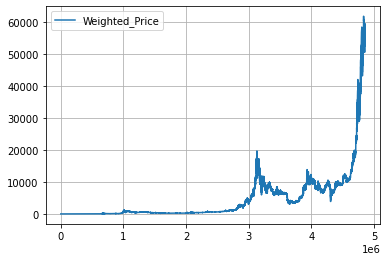

In [19]:
dataset[['Weighted_Price']].plot(grid=True)
plt.show();

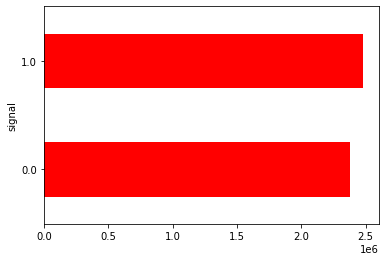

In [20]:
fig = plt.figure()
plot = dataset.groupby(['signal']).size().plot(kind='barh', color='red')
plt.show()

In [22]:
# split out validation dataset for the end
subset_dataset= dataset.iloc[-100000:]
Y= subset_dataset["signal"]
X = subset_dataset.loc[:, dataset.columns != 'signal']
validation_size = 0.2
seed = 1
X_train, X_validation, Y_train, Y_validation =\
train_test_split(X, Y, test_size=validation_size, random_state=1)

In [23]:
# test options for classification
num_folds = 10
scoring = 'accuracy'
models = []
models.append(('LR', LogisticRegression(n_jobs=-1)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
#Neural Network
models.append(('NN', MLPClassifier()))
# Ensemble Models
# Boosting methods
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
# Bagging methods
models.append(('RF', RandomForestClassifier(n_jobs=-1)))

# k fold cross validation

In [26]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds,shuffle=True, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.967300 (0.005810)
LDA: 0.939038 (0.002670)
KNN: 0.655613 (0.004721)
CART: 0.908887 (0.003309)
NB: 0.765550 (0.005098)
NN: 0.793425 (0.068100)
AB: 0.900950 (0.003290)
GBM: 0.918987 (0.002553)
RF: 0.929788 (0.002263)


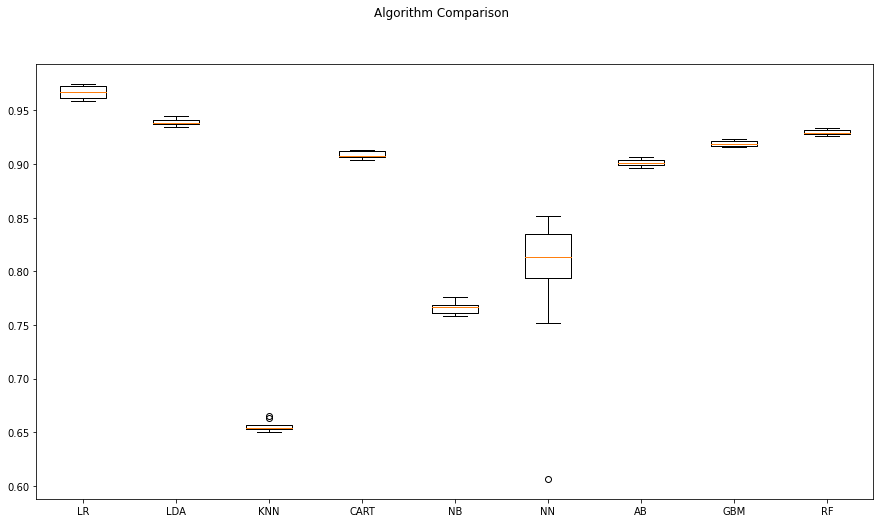

In [27]:
# compare algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

# Model Tuning and Grid Search

In [28]:
# Grid Search: Random Forest Classifier
'''
n_estimators : int (default=100)
    The number of boosting stages to perform. 
    Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.
max_depth : integer, optional (default=3)
    maximum depth of the individual regression estimators. 
    The maximum depth limits the number of nodes in the tree. 
    Tune this parameter for best performance; the best value depends on the interaction of the input variables    
criterion : string, optional (default=”gini”)
    The function to measure the quality of a split. 
    Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. 
    
'''   
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
n_estimators = [20,80]
max_depth= [5,10]
criterion = ["gini","entropy"]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, criterion = criterion )
model = RandomForestClassifier(n_jobs=-1)
kfold = KFold(n_splits=num_folds,shuffle=True, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.908813 using {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 80}
#8 0.872762 (0.004359) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 20}
#5 0.876038 (0.002776) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 80}
#3 0.906413 (0.002902) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 20}
#1 0.908813 (0.002357) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 80}
#7 0.873637 (0.004655) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 20}
#6 0.873650 (0.003170) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 80}
#4 0.905950 (0.003058) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 20}
#2 0.906888 (0.002560) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 80}


In [29]:
# prepare model
model = RandomForestClassifier(criterion='gini', n_estimators=80,max_depth=10,n_jobs=-1) # rbf is default kernel
#model = LogisticRegression() 
model.fit(X_train, Y_train)

RandomForestClassifier(max_depth=10, n_estimators=80, n_jobs=-1)

In [30]:
# estimate accuracy on validation set
predictions = model.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.9102
[[8405  947]
 [ 849 9799]]
              precision    recall  f1-score   support

         0.0       0.91      0.90      0.90      9352
         1.0       0.91      0.92      0.92     10648

    accuracy                           0.91     20000
   macro avg       0.91      0.91      0.91     20000
weighted avg       0.91      0.91      0.91     20000



<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

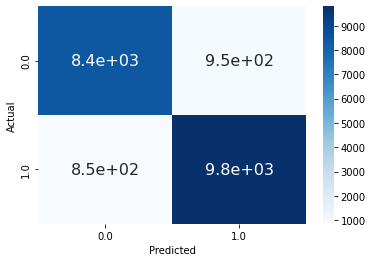

In [31]:
df_cm = pd.DataFrame(confusion_matrix(Y_validation, predictions), columns=np.unique(Y_validation), index = np.unique(Y_validation))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font sizes

Text(0.5, 0, 'Variable Importance')

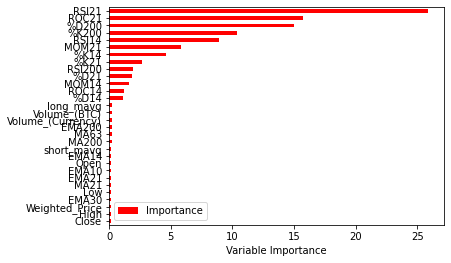

In [32]:
Importance = pd.DataFrame({'Importance':model.feature_importances_*100}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r' )
plt.xlabel('Variable Importance')

#  Backtesting Results

<AxesSubplot:>

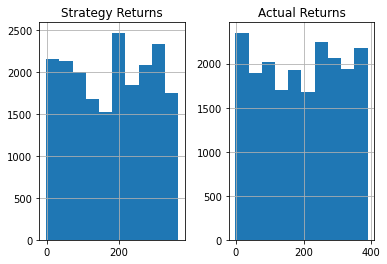

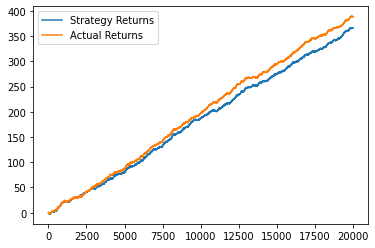

In [33]:
#Create column for Strategy Returns by multiplying the daily returns by the position that was held at close
#of business the previous day
backtestdata = pd.DataFrame(index=X_validation.index)
#backtestdata = pd.DataFrame()
backtestdata['signal_pred'] = predictions
backtestdata['signal_actual'] = Y_validation
backtestdata['Market Returns'] = X_validation['Close'].pct_change()
backtestdata['Actual Returns'] = backtestdata['Market Returns'] * backtestdata['signal_actual'].shift(1)
backtestdata['Strategy Returns'] = backtestdata['Market Returns'] * backtestdata['signal_pred'].shift(1)
backtestdata=backtestdata.reset_index()
backtestdata.head()
backtestdata[['Strategy Returns','Actual Returns']].cumsum().hist()
backtestdata[['Strategy Returns','Actual Returns']].cumsum().plot()